# Tutorial - evaluate three binary classifiers on a test from the UCI Adult dataset

This tutorial is going to walk through a single evaluation that was carried out on three binary classifiers trained and tested on the UCI Adult dataset. Two algebraic evaluators will be used. The first is the one you may be familiar with - using majority voting to impute the missing answer key to the unlabeled test. The second is hardly known to the ML/AI community - the exact, algebraic solution for error-independent ensembles and the basis of Data Engine's 2010 patent.

![table](../../../img/uciAdultEvalPrevalenceGauges.png)

The gauges above show that, for this particular test, the error-independent algebraic evaluator (AE) gets better estimates than the one obtained using majority voting (assuming the crowd is always right).

When you look at the estimated label accuracies for the three members of the ensemble in this test, the advantages of algebraic evaluation over majority voting become apparent.

![table](../../../img/uciAdultEvalPiaGauges.png)

The majority voting evaluation is terrible. It incorrectly asserts that all three classifiers are worse than average on the "a" label, whereas, in reality, the problematic classifier here is the second one.

This problematic evaluation by majority voting can be traced back to the assumption that underlies using the crowd to impute the missing answer key to any test - the crowd is always right. This not true in general - the classifiers could all be better than random guessers and they would **still** make wrong decisions as a group.

## Walking through estimating the label prevalences in the test

In [1]:
from pprint import pprint, pp
import ntqr

There is a data sketch of a test using the UCI Adult dataset that contains the by-label voting counts of three binary classifiers.

In [2]:
labeled_counts = ntqr.uciadult_label_counts

In [3]:
pprint(labeled_counts)

{'a': {('a', 'a', 'a'): 715,
       ('a', 'a', 'b'): 161,
       ('a', 'b', 'a'): 2406,
       ('a', 'b', 'b'): 455,
       ('b', 'a', 'a'): 290,
       ('b', 'a', 'b'): 94,
       ('b', 'b', 'a'): 1335,
       ('b', 'b', 'b'): 231},
 'b': {('a', 'a', 'a'): 271,
       ('a', 'a', 'b'): 469,
       ('a', 'b', 'a'): 3395,
       ('a', 'b', 'b'): 7517,
       ('b', 'a', 'a'): 272,
       ('b', 'a', 'b'): 399,
       ('b', 'b', 'a'): 6377,
       ('b', 'b', 'b'): 12455}}


In an unsupervised setting, we do not know the true label for any item. All we get to see are the decisions the classifiers made. These are in effect, the sum of the above counts across the different labels. There is a class for operating on the labeled counts that can give us the projected counts.

In [4]:
trio_labeled_counts = ntqr.TrioLabelVoteCounts(labeled_counts)
pprint(trio_labeled_counts)

TrioLabelVoteCounts(label_vote_counts={'a': {('a', 'a', 'a'): 715,
                                             ('a', 'a', 'b'): 161,
                                             ('a', 'b', 'a'): 2406,
                                             ('a', 'b', 'b'): 455,
                                             ('b', 'a', 'a'): 290,
                                             ('b', 'a', 'b'): 94,
                                             ('b', 'b', 'a'): 1335,
                                             ('b', 'b', 'b'): 231},
                                       'b': {('a', 'a', 'a'): 271,
                                             ('a', 'a', 'b'): 469,
                                             ('a', 'b', 'a'): 3395,
                                             ('a', 'b', 'b'): 7517,
                                             ('b', 'a', 'a'): 272,
                                             ('b', 'a', 'b'): 399,
                                             ('b', 'b', 'a

The class TrioLabelVoteCounts can project the counts across labels for us and give us only the vote pattern counts.

In [5]:
trio_vote_counts = trio_labeled_counts.to_TrioVoteCounts()
pprint(trio_vote_counts)

TrioVoteCounts(vote_counts={('a', 'a', 'a'): 986,
                            ('a', 'a', 'b'): 630,
                            ('a', 'b', 'a'): 5801,
                            ('a', 'b', 'b'): 7972,
                            ('b', 'a', 'a'): 562,
                            ('b', 'a', 'b'): 493,
                            ('b', 'b', 'a'): 7712,
                            ('b', 'b', 'b'): 12686})


The challenge in unsupervised evaluation is to go from these counts back to the by-label counts. Let's see what happens when you use an algebraic evaluation that assumes that the classifiers were error independent on this test.

In [6]:
algebraic_eval = ntqr.ErrorIndependentEvaluation(trio_vote_counts)

In [7]:
ae_eval = algebraic_eval.evaluation_exact
pprint(ae_eval[0]["prevalence"])

{'a': 1/2 - 11187722681*sqrt(3328641826009)/61316911076911789,
 'b': 11187722681*sqrt(3328641826009)/61316911076911789 + 1/2}


The two possible solutions for the 'a' label prevalence contain an unresolved square root. This means that the error independence assumption is wrong! The three classifiers in the test have non-zero error correlations. But let us see how close this irrational number is to the actual value.

In [8]:
ae_evalf = algebraic_eval.evaluation_float
pprint(ae_evalf[0]["prevalence"])

{'a': 0.16711443965305095, 'b': 0.832885560346949}


The correct evaluation can be computed with the labeled counts.

In [9]:
supervised_eval = ntqr.SupervisedEvaluation(trio_labeled_counts)
seval_exact = supervised_eval.evaluation_exact
seval_float = supervised_eval.evaluation_float

In [10]:
seval_float["prevalence"]

{'a': 0.15436186960534173, 'b': 0.8456381303946583}

So the error independent algebraic evaluation is 16.7% and the true 'a' label prevalence is 15.4%. Not bad. How does majority voting do on this test as an evaluator?

In [11]:
majority_voting_eval = ntqr.MajorityVotingEvaluation(trio_vote_counts)
mv_eval_exact = majority_voting_eval.evaluation_exact
mv_eval_float = majority_voting_eval.evaluation_float

Majority voting does not warn you that the classifiers are actually error correlated since it can only produce rational estimates.

In [12]:
mv_eval_exact[0]["prevalence"]

{'a': Fraction(7979, 36842), 'b': Fraction(28863, 36842)}

In [13]:
mv_eval_float[0]["prevalence"]

{'a': 0.2165734759242169, 'b': 0.7834265240757831}

To summarize - the true 'a' label prevalence is 15.4%, algebraic evaluation estimates 16.7%, and majority voting 21.7%

## The label accuracies

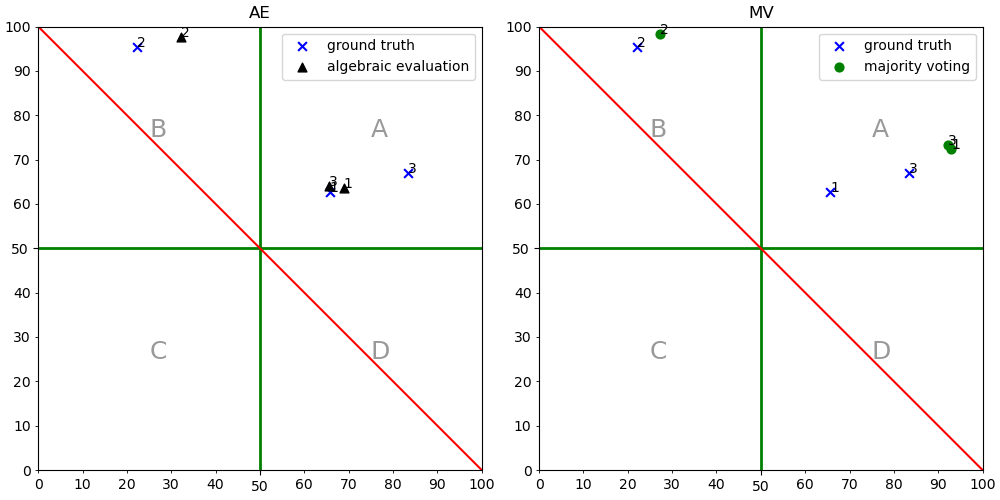

In [14]:
%matplotlib widget
from ntqr.r2.plots import compare_evaluations
mv_exact = majority_voting_eval.evaluation_exact
size=40
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["algebraic evaluation",
     [d['a']*100 for d in ae_eval[0]["accuracy"]],
     [d['b']*100 for d in ae_eval[0]["accuracy"]],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_exact[0]["accuracy"]],
    [d['b']*100 for d in mv_exact[0]["accuracy"]],
    "o", "g",size]],0,
    titles=["GT","AE","MV"],figsize=(10,5),legend_loc="best")

The results for algebraic evaluation look sort of okay. Can we do better? Yes. The next section explains how we can by looking for the nearest logically possible evaluations.

## Correcting the logically inconsistent error-independent solution for dependent classifiers

There is a theorem confirming that an unresolved square root means the classifiers are not error-independent on the given data sketch. We will deal later with the case of highly correlated classifiers. For now we will focus on the case of **nearly independent** classifiers. This applies in the UCI Adult example we have been using throughout this notebook. The pair correlations are less than 1% on all pairs.

Since there is an unresolved square root in the prevalence estimate, we know that the "raw" algebraic evaluation we did with the error-independent is not logically consistent not with the axioms themselves - the independent solution solves them - but because of the semantics of taking a finite test - only rationals are possible evaluations.

This section will use this idea to find the nearest logically consistent **rational** solution. To do this we access some Python classes that implement the computations needed to find the only possible evaluations consistent with the observed responses of the classifiers.

In [15]:
from ntqr.r2.evaluations import PosteriorSingleEvaluations

# We now move to the space of integer responses
# The solutions are going to be parametrized by the size of the test
trio_vote_counts.test_size

36842

In [16]:
poss_evals = PosteriorSingleEvaluations(trio_vote_counts)

In [23]:
# Let's move all our evaluation values to integer space
# TODO: Create class that does this from the integer data sketch
aprev = ae_eval[0]["prevalence"]["a"]
aprev

1/2 - 11187722681*sqrt(3328641826009)/61316911076911789

In [26]:
aprevf = float(aprev*trio_vote_counts.test_size)
aprevf

6156.830185697703

In [32]:
pp(supervised_eval.evaluation_exact["prevalence"])
pp(majority_voting_eval.evaluation_exact[0]["prevalence"])

{'a': Fraction(5687, 36842), 'b': Fraction(31155, 36842)}
{'a': Fraction(7979, 36842), 'b': Fraction(28863, 36842)}
